# Logistic regression: Handwritten Digit Recognition

## Created by Logan Nelson
#### See github for licensing.
### logan.b.nelson@gmail.com, nelso566@purdue.edu, 818-925-6426

This notebook uses the classic [MNIST handwritten digit](http://yann.lecun.com/exdb/mnist/) dataset, which contains digit 0-9 images of size 28*28. This can be used as self contained program for handwritten digit recognition of a file of data or as pieces to be implemented in other code. This is optimized for greyscale digit recognition.

If you have not yet installed any of the following packages they are required. Simply uncomment and run at least one time, or install using your preffered package installer.

In [1]:
# !pip install tensorflow
# !pip install pillow

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import time

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

from PIL import Image

### Let's set up a few functions

In [3]:
def get_epochs():
    while True:
        try:
            return int(input("How many epochs would you like to run? (Default is 25, press Enter for default): ") or 25)
        except ValueError:
            print("Please enter a valid integer.")
            
def build_model():
    model = keras.Sequential([layers.Dense(10, 
                                           input_dim=input_dim, 
                                           activation='sigmoid')])
    
    optimizer = keras.optimizers.Adam(0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

def build_digit_recognition_model(input_shape, num_classes=10):
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'])

    plt.show()
    
# Display training progress by printing a single dot for each completed epoch

class PrintLoss(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch == 0: self.time = time.monotonic()
            
    def on_epoch_end(self, epoch, logs):
        # calculate training time
        t = time.monotonic() - self.time
        # if validation set is included, its loss is recorded in logs['val_loss']
        print('| Epoch {:4} | training time {:6.2f}s | train loss {:6.2f} |'
              .format(epoch, t, logs['loss']))
        
def load_and_preprocess_image(image_path, target_size):
    img = Image.open(image_path)

    # Convert the image to grayscale as this model expects grayscale inputs
    img = img.convert('L') 

    # Resize the image to the target size
    img = img.resize(target_size, Image.LANCZOS)

    # Convert the image data to an array and normalize
    img_array = np.array(img) / 255.0

    img_array = np.expand_dims(img_array, axis=-1)

    # Add a batch dimension (model expects a batch, even if it's a single image)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def predict_digit(model, image_path):
    # Assuming your model expects 28x28 images
    img_array = load_and_preprocess_image(image_path, (28, 28))

    # Make a prediction
    prediction = model.predict(img_array)

    # Convert prediction to a readable digit
    predicted_digit = np.argmax(prediction)
    
    return predicted_digit

### Constants and Configurations

In [4]:
(X_train_pre, y_train_pre), (X_validation_pre, y_validation_pre) = mnist.load_data() # MNIST comes split between train and validation sets 
input_dim_MNIST = (28, 28, 1) # These are the dimensions from the library.
num_classes = 10 # 0-9 digits

image_width, image_height = 28, 28
channels = 1  # 1 for grayscale, 3 for RGB

EPOCHS = get_epochs()

user_input = input("Do you want to evaluate an image? Enter Y for Yes or N for No: ")

if user_input.strip().upper() == "Y":
    image_path = input("""Please enter the name of the image you want evaluated. 
    If it is in the same folder as this program, just enter the name.
    If it is not in the same folder, please type the file path with the file name. """)

How many epochs would you like to run? (Default is 25, press Enter for default): 
Do you want to evaluate an image? Enter Y for Yes or N for No: Y
Please enter the name of the image you want evaluated. 
    If it is in the same folder as this program, just enter the name.
    If it is not in the same folder, please type the file path with the file name. 3.jpg


### Visualize MNIST data for reference

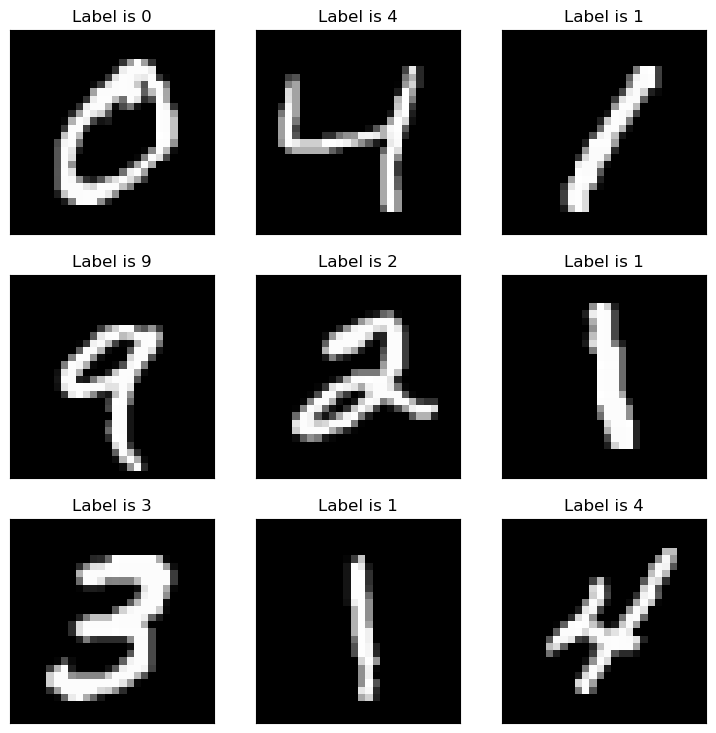

In [5]:
fig = plt.figure(figsize=(9, 9))
col = 3
row = 3
for i in range(1, col*row +1):
    label = y_train_pre[i]
    img = X_train_pre[i,:]
    fig.add_subplot(row, col, i)
    plt.title('Label is {}'.format(label))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()

### Reshape and normalize the features

In [6]:
X_train = X_train_pre.reshape(X_train_pre.shape[0], image_width, image_height, channels)
X_validation = X_validation_pre.reshape(X_validation_pre.shape[0], image_width, image_height, channels)

X_train = X_train.astype('float32') 
X_validation = X_validation.astype('float32') 
X_train /= 255.0 # This normalizes the values for a RGB range of 2^8 possible values for 0-255.
X_validation /= 255.0 # This normalizes the values for a RGB range of 2^8 possible values for 0-255.

print('Training data shape:', X_train.shape)
print('{} train samples, {} validation samples'.format(X_train.shape[0], X_validation.shape[0]))

Training data shape: (60000, 28, 28, 1)
60000 train samples, 10000 validation samples


### Convert class vectors to binary class matrices
Convert class label to one-hot encoding. In one-hot encoding, categorical variables are converted into a form that could be provided to machine learning algorithms to do a better job in prediction.

In [7]:
y_train = keras.utils.to_categorical(y_train_pre, num_classes)
y_validation = keras.utils.to_categorical(y_validation_pre, num_classes)

y_train[:5,] 

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

### Build the model

In [8]:
model = build_digit_recognition_model(input_dim_MNIST, num_classes)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

### Train the model

The below is mostly for seeing behind the curtain. We get the history of the model being trained by each epoch and a visualization to show the accuracy metric over each epoch.

In [10]:
history = model.fit(X_train, y_train,
                    batch_size=32, epochs=EPOCHS,
                    callbacks=[PrintLoss()])

Epoch 1/25
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1945 - accuracy: 0.9412
Epoch 2/25
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0805 - accuracy: 0.9750
Epoch 3/25
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0601 - accuracy: 0.9817
Epoch 4/25
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0504 - accuracy: 0.9843
Epoch 5/25
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0405 - accuracy: 0.9875
Epoch 6/25
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0370 - accuracy: 0.9883
Epoch 7/25
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0324 - accuracy: 0.9898
Epoch 8/25
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0276 - accuracy: 0.9908
Epoch 9/25
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0249 - accuracy: 0.9919
Epoch 10/25
1875/1875 [==============================] - 36s 19m

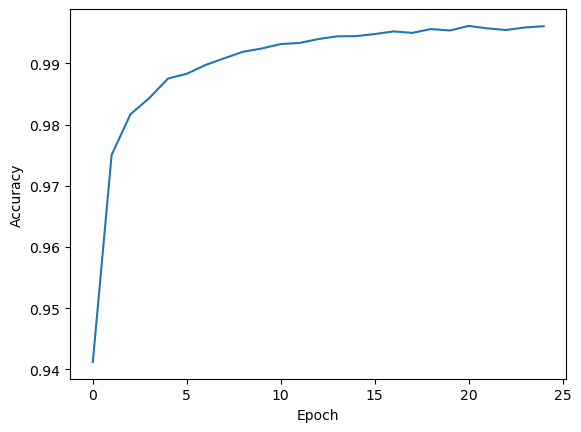

In [11]:
plot_history(history)

### Make predictions

Now we calculate the classification accuracy for the validation set.

In [12]:
_, acc = model.evaluate(X_validation, y_validation, verbose=0)

print("Validation set accuracy: {:.2f}%".format(acc*100))

Validation set accuracy: 99.30%


Now we can check predictions for validation data. We'll just look at 5 examples for the validation set.

In [13]:
y_pred = np.argmax(model.predict(X_validation), axis=-1)
y_pred[:5]

313/313 [==============================] - 1s 5ms/step


array([7, 2, 1, 0, 4], dtype=int64)

Now, we will visualize predictions for the validation set.

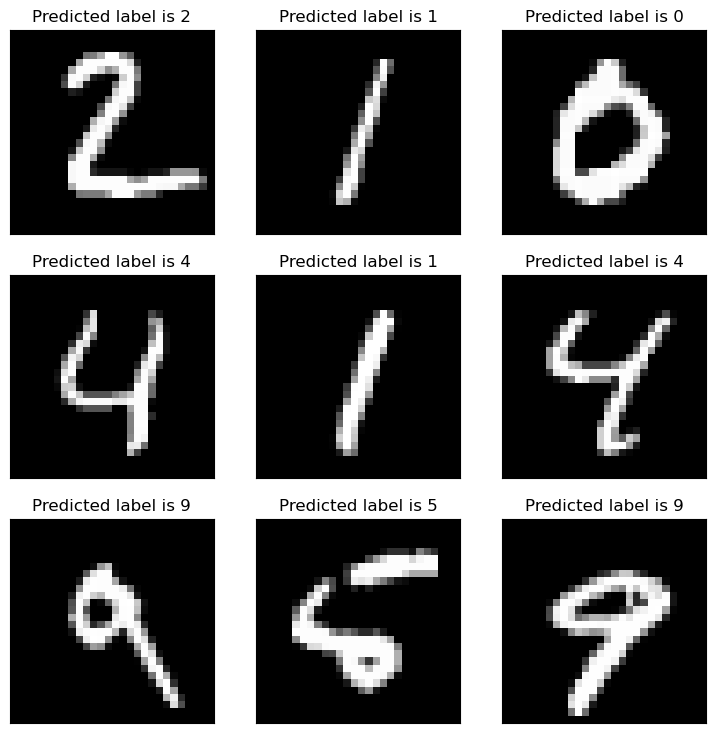

In [14]:
fig = plt.figure(figsize=(9, 9))
col = 3
row = 3
for i in range(1, col*row +1):
    pred = y_pred[i]
    img = X_validation_pre[i,:]
    fig.add_subplot(row, col, i)
    plt.title('Predicted label is {}'.format(pred))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()

If the user has put in their own image, this returns a prediction if desired.

In [15]:
if user_input == "Y":
    your_digit = predict_digit(model, image_path)
    print(f"The predicted digit is: {your_digit}")

1/1 [==============================] - 0s 10ms/step
The predicted digit is: 8
